In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import tensorflow as tf
import edward as ed
from edward.models import Normal
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
sess = ed.get_session()
from tensorflow.contrib.keras.api.keras.models import Sequential
from tensorflow.contrib.keras.api.keras.layers import Dense
from tensorflow.contrib.keras.api.keras.layers import SimpleRNN
from tensorflow.contrib.keras.api.keras.layers import LSTM
from tensorflow.contrib.keras.api.keras.layers import GRU
from tensorflow.contrib.keras.api.keras.layers import Activation

# Predictive Maintenance with Bayesian Recurrent Neural Networks

*Kejia Shi (ks3403) and Zhirui Wang (zw2389)*

Data Science Intitute, Columbia University

## 1. Introduction

Sequentially predicting the time to failure (also known as Remaining Useful Life/RUL) of the engines is vital to ensure the operational safety in manufacturing and all kinds of services, including the management of data servers and scientific research facilities. Collecting and analyzing machine data of working environment and user settings enable us to better model engine degradation beyond pure human extimation.

In this project, we build deep generative models based on the C-MAPSS Data, or the Turbofan Engine Degradation Simulation Data Set from NASA. We predict the time to failure (RUL) of those engines.

## 2. Review of Methods

This predictive task fits in both churn prediction and survival contexts. However, our context still differs from traditional methods a lot:

- No theoretical models on such simulated dataset with no feature labels to back up survival analysis
- (further) No additional model parameters given
- No guarantee on less cautious data preprocess and feature engineering
- Want some model flexibility
- ...

(see Appendix notebook for detailed summarization)

Our models extend the usage of recurrent neural network for churn predictions ([Uz, 2017](https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb)) to noisy settings.

The recurrent neural network may be able to capture the hidden data relationships, save us time for engineering features and uncover temporal patterns in recurrent events. Although traditional recurrent neural network may already be able to give competitive predictions, it treats all model parameters as fixed values.

The baseline Bayesian RNN model differs from the standard RNN with the added distributions over weights and biases. In practice, such added compositional structure for probabilistic programming "compiles" the model down into inference procedures. While we draw model parameters from distributions, uncertainty is taken into consideration. And then we do the inference part, where some up-to-date algorithm can be applied.

## 3. Dataset
### 3.1 Description
[C-MAPSS Data](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan) (Saxena and Goebel, 2008), or the Turbofan Engine Degradation Simulation Data Set from NASA, contains four different sets of simulated engine degradation under different combinations of operational conditions and fault modes.

Training sets and test sets are balanced in the number of observations. Total trajectories in a group is 100 or 250. Each row is a snapshot of data taken during a single operational cycle, while each column is a different variable of the total 26 features.
- `id`: an identification of a single turbofan
- `cycle`: the timestamp starts from 1 when a turbofan start to run
- 3 `settings` and 21 `sensor readings` of the turbofan at chosen timestamps

When a turbofan breaks down, the record of that turbofan will end.

The goal is to sequentially predict the time to failure (also known as Remaining Useful Life/RUL) of the engines.
### 3.2 Preprocessing
Total number of features is 25. 
- Create `RUL` (target variable), for each unique `id`
- Normalized all features (3 `settings` and 21 `sensor readings`)

Then we create sequences of chosen length as the RNN inputs.
- Sequence length 
  - determines how much the most recent information that our prediction is based on
  - provides practical suggestions on machine maintenance in our context

In our early experimentation, we find `sequence_length = 5` performs better than `sequence_length = 20`, which means the most recent status information are more important. This satisfies our expectation, since it's not easy to tell a machine will break down at early states when it can function well for a long time.

As we have tested the inference speed, we decide to only use the 10% training data and the rest 90% as validation data. The prediction would improve, suppose we push all the training dataset into our models. However, our tests below show that with such little amount of data, we have already out-performed the traditional neural networks and achieved a slightly better prediction accuracy than using the full dataset on the traditional network. Therefore, we choose to use only 10% data.

In [2]:
# read training data, test data and groud truth data for test data
train_df = pd.read_csv('../src/data/train_FD001.txt', sep=" ", header=None)
test_df = pd.read_csv('../src/data/test_FD001.txt', sep=" ", header=None)
truth_df = pd.read_csv('../src/data/RUL_FD001.txt', sep=" ", header=None)

In [3]:
# preprocesse the data as described
from util import turbo_preprocessing
train_df, test_df = turbo_preprocessing(train_df,test_df,truth_df)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0.01108


In [4]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0.01108


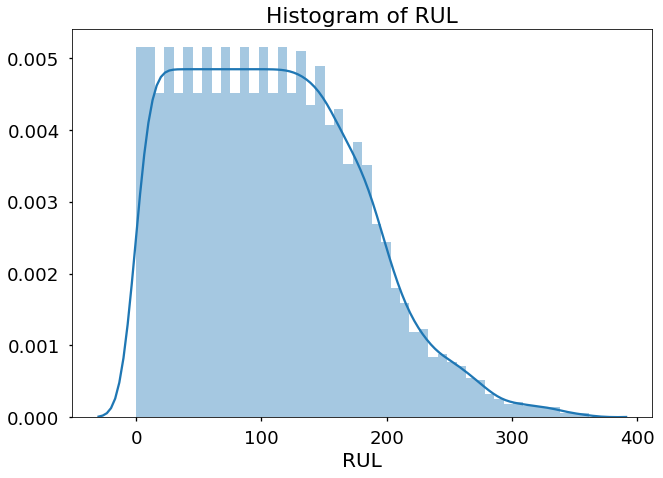

In [5]:
sns.distplot(train_df.RUL)
plt.title('Histogram of RUL')
plt.xlabel('RUL');

In [6]:
# pick a window size of 5 cycles
sequence_length = 5

In [7]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [8]:
# generator for the sequences
from util import gen_sequence
seq_gen = [list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique()]

In [9]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(seq_gen).astype(np.float32)
seq_array.shape

(20131, 5, 25)

In [10]:
# generate labels
from util import gen_labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.squeeze(np.concatenate(label_gen).astype(np.float32))
label_array.shape

(20131,)

In [11]:
seq_array1,seq_array2,label_array1,label_array2 = train_test_split(seq_array,label_array,test_size=0.9,shuffle=False)

In [12]:
less_50 = label_array2<=50

In [13]:
H = 100  # number of hidden units
N,_,D = seq_array1.shape  # number of training data points, number of features
print(f'Number of hidden units is {H},\nNumber of training data points is {N},\nLength of sequence is {sequence_length},\nNumber of features is {D}')

Number of hidden units is 100,
Number of training data points is 2013,
Length of sequence is 5,
Number of features is 25


## 4. Models

We provide the results of 7 models varying by the number of layers, the recurrent unit choice and whether we use noisy network or not.

- Layers: 1 layer [100], 2 layers [100, 50]
- RNN unit: Basic RNN, LSTM, GRU (also feedforward)
- With or without priors

We choose our baseline models to be the standard LSTM network without priors and the feedforward network with priors. Results from all other models based on these two models are summarized in later parts. (All models' code can be found in `codebase/bnn/models.py`.) Now we demo two representative models.

- 1-layer standard LSTM network
- 1-layer Bayesian LSTM network

A Long Short-Term Memory(**LSTM**) unit:
<img src="../src/out/LSTM.png" alt="LSTM Gating. Chung, Junyoung, et al. “Empirical evaluation of gated recurrent neural networks on sequence modeling.” (2014)" style="width: 300px;"/>

**The standard LSTM network is built as follows:**

In [17]:
model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, D),
         units=H))

model.add(Dense(units=1))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


**The Bayesian LSTM network:**

$\text{Gaussian}(0,1)$ prior on all weights and biases

$\text{Gaussian}(\text{y_output},1)$ data likehood

In [18]:
def rnn_cell_sig(hprev, xt, Wh, Wx, bh):
    return tf.sigmoid(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

def rnn_cell_tanh(hprev, xt, Wh, Wx, bh):
    return tf.tanh(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

def LSTM_cell(hprev, cprev, xt, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc):
    f = rnn_cell_sig(hprev, xt, Wf, Uf, bf)
    i = rnn_cell_sig(hprev, xt, Wi, Ui, bi)
    o = rnn_cell_sig(hprev, xt, Wo, Uo, bo)
    c = f*cprev + i*rnn_cell_tanh(hprev, xt, Wc, Uc, bc)
    h = o*tf.tanh(c)
    return h,c

def LSTM_layer(X, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc, Wy, by, H):
    N, sequence_length, D = X.get_shape().as_list()
    h = tf.zeros([N,H])
    c = tf.zeros([N,H])
    for i in range(sequence_length):
        h,c = LSTM_cell(h, c, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc)
    return tf.reshape(tf.matmul(h, Wy) + by,[-1])


Wf = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uf = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wi = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Ui = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wo = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uo = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wc = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uc = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wy = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
bf = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bi = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bo = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bc = Normal(loc=tf.zeros(H), scale=tf.ones(H))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=LSTM_layer(X, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc, Wy, by, H), scale=1.)

## 5. Inference

### 5.1 Back Propagation (on Standard Neural Network)

Inputs are forward propagated to get outputs. The model parameters are updated through backward propagation of loss function. `tensorflow.keras` uses MSE as loss and Nesterov Adam optimizer.

In [19]:
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
model.fit(seq_array1, label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2,label_array2), verbose=0);

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### 5.2 Black-Box Variational Inference

All variational distritions are set as normal distributions.  

Model tuning suggests us to use 5 samples and 2500 iterations for BBVI.

In [20]:
# BACKWARD MODEL A
q_Wf = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uf = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wi = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Ui = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wo = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uo = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wc = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uc = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, 1]))))
q_bf = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bi = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bo = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bc = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [21]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wf: q_Wf, Uf: q_Uf, Wi: q_Wi, Ui: q_Ui, Wo: q_Wo, Uo: q_Uo, Wc: q_Wc, Uc: q_Uc,
                                 bf: q_bf, bi: q_bi, bo: q_bo, bc: q_bc, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 647s | Loss: 186105.672


### 5.3 Experimentation: Bayes by Backprop

Algorithm:

$L(\theta)=E_{q(\theta)}[\log p(y,\theta|X)-\log q(\theta)]=E_{q(\theta)}[\log p(y|\theta,X)]-\text{KL}(q(\theta)||p(\theta))$

- Sample $\epsilon\in N(0,I)$, $\epsilon\in R^d$
- Set network parameters to $\theta=\mu+\sigma\epsilon$
- Forward propagation and backpropagation as usual
  - Let $g$ be the gradient w.r.t. $\theta$ from backpropagation
- Let $g_\theta^{\text{KL}}$, $g_\mu^{\text{KL}}$ and $g_\sigma^{\text{KL}}$ be the gradients of $\log N(\theta |\mu,\sigma)-\log p(\theta)$
- Update $\Delta\mu=g+g_\theta^{\text{KL}}+g_\mu^{\text{KL}}$, $\Delta\sigma=(g+g_\theta^{\text{KL}})\epsilon+g_\sigma^{\text{KL}}$

A minibatch setting slightly edits the above algorithm with an additional constant factor $\frac{1}{\text{n_batch}}$ before the KL term. This improves our inference speed as estimated.

Code see `codebase/experiment/` and `notebook/pp-appendix-2-ks3403-zw2389.ipynb`.

## 6. Criticism

<center>Model Results summarization</center>

| Model                 | Inference   | RMSE   | (<50 days) | Inference   | RMSE   | (<50 days) |
|-----------------------|-------------|--------|---------------|-------------|--------|---------------|
| Fully Connected Layer | Frequentist | **42.576** | 18.659        | Bayesian    | 42.811 | 15.082        |
| Simple RNN            | Frequentist | 47.970 | 10.702        | Bayesian    | 43.369 | 13.645        |
| LSTM                  | Frequentist | **41.268** | 12.512        | Bayesian    | 45.123 | **10.249**        |
| GRU                   | Frequentist | **42.571** | 11.345        | Bayesian    | 45.095 | **10.442**        |
| Two Layer RNN         | Frequentist | 43.120 | 12.644        | Bayesian    | 47.874 | 21.788        |
| Two Layer LSTM        | Frequentist | /      | /             | Bayesian    | 44.395 | **10.530**        |
| Two Layer GRU         | Frequentist | /      | /             | Bayesian    | 44.278 | 11.108        |


The metric we use is **RMSE**. Notice the same line of the two networks share the same model parameters.

Within the full machine cycles, the best results come from standard neural nets. As we have injected much noise into the nets, especially in the RNNs, noisy nets perform worse. However, this has a lot to do with the large deviation of predictions introduced at the beginning of machines' life cycles. (shown in the below visualization)

For example, a turbofan at 200 days before breakdown can have very similar feature values as at 150 days to failure, since the machine degradation has not yet started. This won't be the same at 51 days to 1 day to failure. Therefore, a better metric we adopt is **RMSE of less than 50 days to failure**.

As we limit our focus to the new metric, Bayesian recurrent neural nets maintain a better prediction power than standard RNNs.

Moreover, in our experimentation, the standard RNNs are more sensitive to model parameter change, while the Bayesian inference is more robust. The Bayesian inference with change of model parameters always converge to the similar results as shown above.

Below we summarize our model choosing insights through four types of plots:

- Predicted RUL histograms (as against the true histogram plot above)
- RUL predictions against truth per machine (last 1500 records in validation set)
  - Along with (zoomed) posterior predictions for last 150 records

**a. Predicted RUL histogram**
<center>Frequentist Histogram Comparison</center>
![Frequentist Histogram Comparison](../src/out/4_freq_hist.png)
<center>Bayesian Histogram Comparison</center>
![Bayesian Histogram Comparison](../src/out/4_bayes_hist.png)
<center>Two Layer Histogram Comparison</center>
![Two Layer Histogram Comparison](../src/out/4_bayes_hist_twolayer.png)

Firstly, from the histogram of the truth dataset, the peak RUL is around 0-150, which is followed by a gradual decrease of counts to 400.

In our predictions, all of the standard nets have their max values around 200 and all of the Bayesian models have their max values around 250 (except for two layer RNN). Bayesian inference stands out in predicting extreme values.

For both the standard and the Bayesian infered models, LSTM and GRU share similar histograms that are close to the  truth histogram. They manage to predict the small RULs (from 0 to 25), which fully connected models fail to. They also resemble the shape of the true RULs, compared to feed forward nets.

In Bayesian inference, the predictions have three modes around 50, 100 and 200.

**b. RUL Prediction against truth per machine**
<center>Frequentist Prediction Comparison</center>
![Frequentist Prediction Comparison](../src/out/4_freq_pred.png)
<center>Posterior Prediction Distribution Comparison(Last 1500 Days)</center>
![Posterior Prediction Distribution Comparison](../src/out/4_bayes_pred_dist1500.png)
<center>Two Layers Posterior Prediction Distribution Comparison(Last 1500 Days)</center>
![Two Layers Posterior Prediction Distribution Comparison](../src/out/4_bayes_pred_dist1500_twolayer.png)
<center>Posterior Prediction Distribution Comparison(Last 150 Days)</center>
![Posterior Prediction Distribution Comparison](../src/out/4_bayes_pred_dist150.png)
<center>Two Layers Posterior Prediction Distribution Comparison(Last 150 Days)</center>
![Two Layers Posterior Prediction Distribution Comparison](../src/out/4_bayes_pred_dist150_twolayer.png)

In sum:

- LSTM and GRU models are better than RNN models, since we expect low variance from posterior distributions.
- Although the feed forward Bayesian net has low variance, the mean predictive values do not align the true values. It may be because of less noise introduced from less number of weights.
- One-layer recurrent models demonstrate desire behaviors compared to two-layer models. This may be related to the inclusion of more noisy weights.

We code demo the Bayesian 1-layer LSTM model visualization on the test set as follows.

In [23]:
# generator for the sequences
seq_gen_test = [list(gen_sequence(test_df[test_df['id']==id], sequence_length, sequence_cols)) 
           for id in test_df['id'].unique()]

In [24]:
# generate sequences and convert to numpy array
seq_array_test = np.concatenate(seq_gen_test).astype(np.float32)
seq_array_test.shape

(12596, 5, 25)

In [25]:
# generate labels
label_gen_test = [gen_labels(test_df[test_df['id']==id], sequence_length, ['RUL']) 
             for id in test_df['id'].unique()]
label_array_test = np.squeeze(np.concatenate(label_gen_test).astype(np.float32))
label_array_test.shape

(12596,)

In [26]:
less_50_test = label_array_test <= 50

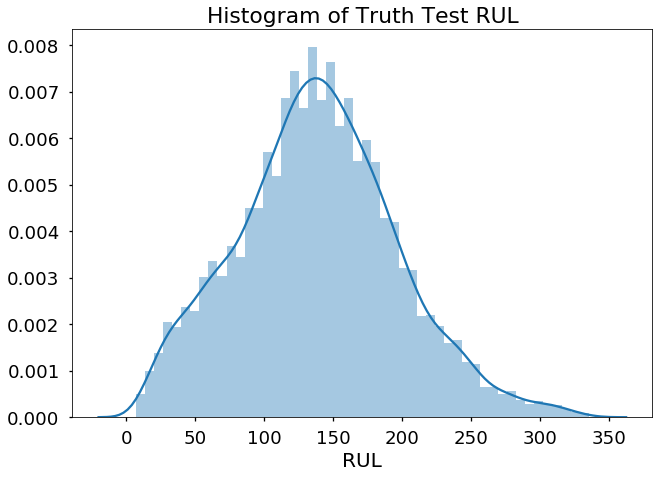

In [27]:
sns.distplot(label_array_test)
plt.title('Histogram of Truth Test RUL')
plt.xlabel('RUL');

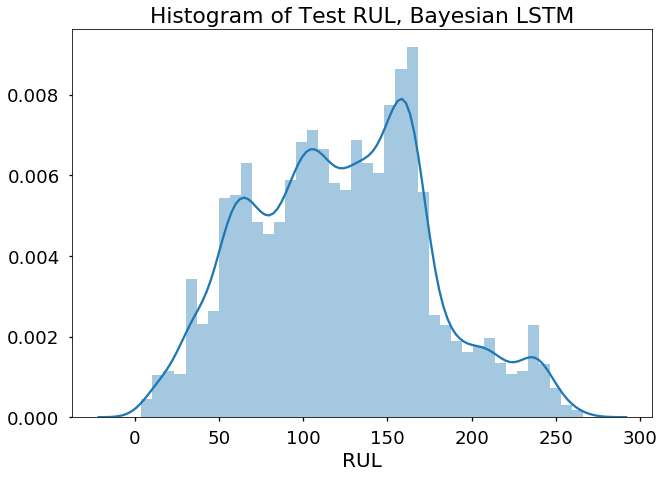

In [28]:
Xp = tf.placeholder(tf.float32,seq_array_test.shape)
y_preds = [sess.run(LSTM_layer(Xp, q_Wf, q_Uf, q_Wi, q_Ui, q_Wo, q_Uo, q_Wc, q_Uc, 
                             q_bf, q_bi, q_bo, q_bc, q_Wy, q_by, H),{Xp:seq_array_test})
          for _ in range(50)]
sns.distplot(y_preds[0])
plt.title('Histogram of Test RUL, Bayesian LSTM')
plt.xlabel('RUL');

In [29]:
print(f'Average Validation RMSE: {np.mean([np.sqrt(mean_squared_error(label_array_test,y_pred)) for y_pred in y_preds])}')

Average Validation RMSE: 49.007530212402344


In [30]:
print(f'Average Validation RMSE for RUL under 50: {np.mean([np.sqrt(mean_squared_error(label_array_test[less_50_test],\
      y_pred[less_50_test])) for y_pred in y_preds])}')

Average Validation RMSE for RUL under 50: 16.494457244873047


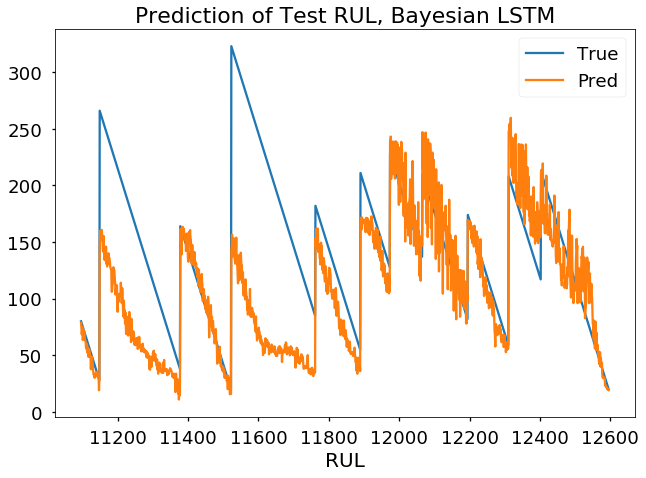

In [31]:
pd.DataFrame([label_array_test,y_preds[0]]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of Test RUL, Bayesian LSTM')
plt.xlabel('RUL');

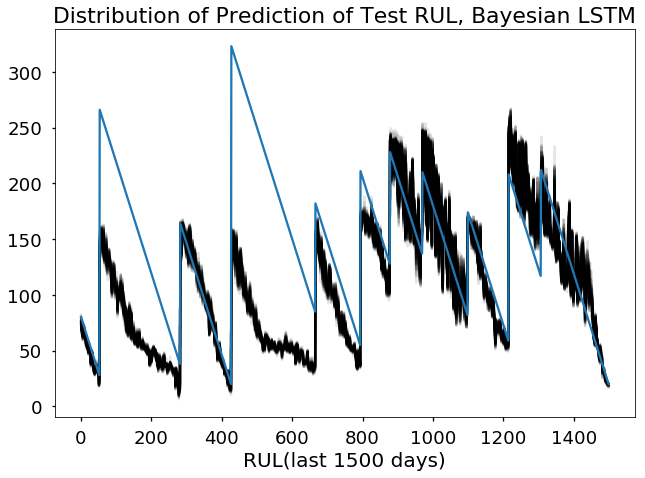

In [32]:
[plt.plot(y_pred[-1500:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array_test[-1500:])
plt.title('Distribution of Prediction of Test RUL, Bayesian LSTM')
plt.xlabel('RUL(last 1500 days)');

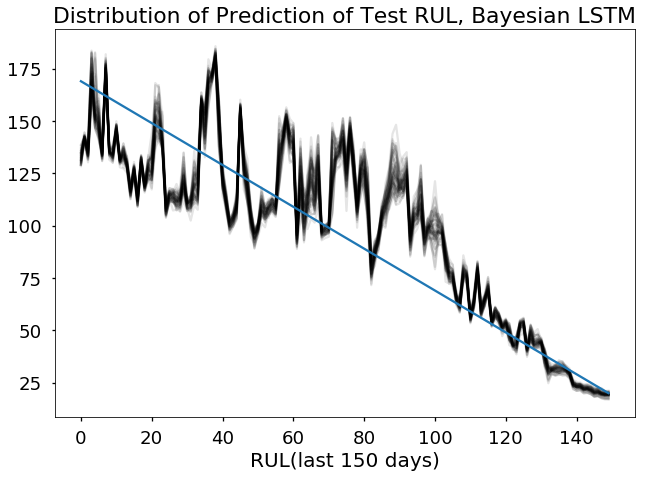

In [33]:
[plt.plot(y_pred[-150:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array_test[-150:])
plt.title('Distribution of Prediction of Test RUL, Bayesian LSTM')
plt.xlabel('RUL(last 150 days)');

### Experimentation: Bayes by Backprop

We manage to test the Bayesian recurrent models on the Penn Tree Bank dataset as provided in the original dataset. It shows promising results (although not the same promising as the [original paper](https://arxiv.org/abs/1704.02798), original paper: 74.8, ours ~90-110 after 60 epochs)

However, it is evident that the whole inference speeds up as we don't require additional gradients other than those ones through backpropagation and gradients of simple KL terms.

In our experimentation, we succeed in building a flexible noisy LSTM model based on editing the Penn Tree Bank tutorials in `Tensorflow`. The current state of this development gets stuck at a bug that fails to add summary into the `dynamic_rnn` cell. The rest of the code is complete. (code and more explaination on the bug see `codebase/experiment/` and `notebook/pp-appendix-2-ks3403-zw2389.ipynb`.)

### References

1. [Bayesian Recurrent Neural Networks](https://arxiv.org/abs/1704.02798)
Meire Fortunato, Charles Blundell, Oriol Vinyals, 2017

2. [Weight Uncertainty in Neural Networks](https://arxiv.org/abs/1505.05424)
Charles Blundell, Julien Cornebise, Koray Kavukcuoglu, Daan Wierstra, 2017

3. [Tenforflow RNN tutorial](https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb)

4. [@mirceamironenco's implementation on the PTB dataset](https://github.com/mirceamironenco/BayesianRecurrentNN/blob/master/bayesian_rnn.py)